In [1]:
%load_ext autoreload
%autoreload 2
%pip install lightning -q

Note: you may need to restart the kernel to use updated packages.


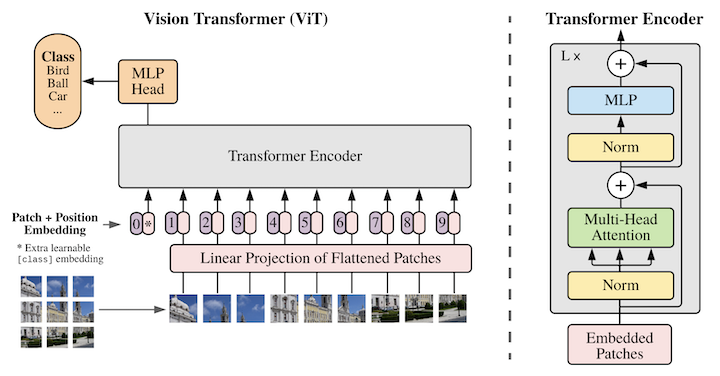

In [38]:
import os
import copy

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torchmetrics.functional import accuracy

try:
    import lightning.pytorch as pl
except ImportError:
    import pytorch_lightning as pl

# Locally defined stuff
from utils.data import MNISTDataModule
from utils.models import ViTModel
from utils.privacy import simple_mia
from utils.utils import num_parameters
from utils.utils import compute_mean_std
from utils.utils import freeze_layers
from utils.visual import show_imgs
from utils.visual import show_history_csv

config = {
    'model': {
        'patch_size': 4,
        'hidden_size': 24,
        'num_hidden_layers': 4,
        'num_attention_heads': 4,
        'intermediate_size': 4 * 24,
        'hidden_dropout': 0.0,
        'attention_probs_dropout': 0.0,
        'position_method': 'random',
        'image_size': 28,
        'num_classes': 10,
        'num_channels': 1,
        'qkv_bias': True,
    },
    'train': {
        'learning_rate': 1e-2,
        'weight_decay': 1e-2,
        'num_epochs': 30,
    },
    'data': {
        'batch_size': 256,
    }
}

# Model Definition

_(See `model.py` for implementation)_

* The high level architecture is shown above.
* The model consists of the following
    * Patch projection (`PatchPreEmbedding`) -- the image is split into patches, and projected onto embedding space
    * Embedding (`VisionEmbedding`) -- the embedding is performed per patch, and an additional `[CLS]` token is learned. The purpose is to have a learnable aggregating token per image
    * XFormer encoder
    * MLP Head for classification

## Embedding Layer

ViT embeddings is defined as following the steps

1. **Patching**:
A simple separation of elements, such that any image $X: \mathbb{R}^{R\times C}$ is decomposed into non-overlapping segments $[x_{11}, x_{12}, \dots, x_{mn}]$, where $x_{ij}:\mathbb{R}^{R/m\times C/n}$ is a patch at location $(im, jn)$.
2. **Flattening**:
A transformation of the 2D represenation into 1D, such that $f: \mathbb{R}^{M\times N}\rightarrow\mathbb{R}^{MN}$
3. **Projection**:
Transformation of discrete representation (flattened image) into a continuous vector space.
This is defined by $Pr: \mathbb{R}\rightarrow\mathbb{R}$, such that $Pr(x_i; \theta)=x_i\theta$
4. **Class and position embedding**
Injecting the class and position into the patch embeddings could be defined as
$$
f(X, n)
= \begin{bmatrix}
\{CLS\}\\Pr(x_{1})\\Pr(x_{2})\\\dots\\ Pr(x_{n})
\end{bmatrix}
+ \begin{bmatrix}
0 / n\\1/n\\2/n\\\dots\\n/n
\end{bmatrix}
$$
where $\{CLS\}$ is a learnable token, and $x_i$ is the $i$-th patch.
Note that the position could also be learnable.

Notice that patching and projection could be done as a convolutional operation with kernel size of `patch_size` and stride of `patch_size`.



## Transformer Block

Transformer block consists of normalization, multihead attention, followed by normalization and linear projection (MLP).
To stay true to the original implementation, the activation function inside MLP is [`NewGELUActivation`](https://github.com/huggingface/transformers/blob/415e9a0980b00ef230d850bff7ecf0021c52640d/src/transformers/activations.py#L50).

Because our goal is to play around with the weights (s.a. inject noise and use PEFT), we will reimplement the multihead attention layer.
In practice, we could just use [nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) block.

## ViT

The model consist of the embedding layer followed by an encoder.
The encoder is just a sequence of N transformer blocks.

Just like in BERT, we only use the [CLS] token for preeicting the class.
This is because during training, the [CLS] token serves as a representation for the image.
The rest of the tokens (patches) are support tokens, and only used when the attention of [CLS]
requires it.

This can be intuitively seen as finding a single parameter $z_0^0$, which after transformed $L$ times using the input patches $x_i$ as parameters, generates a correct class $y_i$.
This means that the objective function is $\|y_i-f(z_0^0 | X; \theta)\|$

In [3]:
# This is the lightning wrapper for the ViTModel

class ViTLightning(pl.LightningModule):
    '''Lightning wrapper for the ViTModel

    Args:
        config(dict): Configuration for the model creation and training. The key/value pairs should include
            model -> dict: Model configuration, same as in ViTModel
            train -> dict: Training configuration, with each key being a training hyperparameter
        train_accuracy (bool): Flag to log training accuracy in the history.
                               Note: The accuracy is not neccassarily correct, as we don't set the model to 'eval'
                               before computing the accuracy. Use `.predict` or `.validate` instead
    '''
    def __init__(self, config, train_accuracy=False):
        super().__init__()
        self.config = config
        self.model = ViTModel(config['model'])
        self.train_accuracy = train_accuracy

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(),
                                 lr=self.config['train']['learning_rate'],
                                 weight_decay=self.config['train']['weight_decay'])

    def _shared_eval_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        loss, y_hat = self._shared_step(batch, batch_idx)
        acc = accuracy(y_hat, y, task='multiclass', num_classes=self.model.num_classes)
        return loss, acc

    def _shared_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)[0]
        loss = F.cross_entropy(y_hat, y)
        return loss, y_hat

    def training_step(self, batch, batch_idx, dataloader_idx=0):
        if self.train_accuracy:
            loss, acc = self._shared_eval_step(batch, batch_idx, dataloader_idx)
            metrics = {"train_acc": acc, "train_loss": loss}
        else:
            loss, _ = self._shared_step(batch, batch_idx, dataloader_idx)
            metrics = {"train_loss": loss}       
        self.log_dict(metrics,
                      prog_bar=True,
                      on_step=False,
                      on_epoch=True,
                      logger=True,)
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_acc": acc, "val_loss": loss}
        self.log_dict(metrics,
                      prog_bar=True,
                      on_step=False,
                      on_epoch=True,
                      logger=True,)
        return metrics

In [17]:
model = ViTLightning(config)
num_params = num_parameters(model.model, as_table=True)

print(num_params)

# Sanity check
N = 3
C = 1
H = 28
W = 28

x = torch.randn(N, C, H, W, requires_grad=False)
with torch.no_grad():
    y = model(x)
    assert y[0].shape == (N, config['model']['num_classes'])

     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |     1,632 |       100.00%
encoder.blocks.0 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.1 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.2 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.3 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
classifier       |    250 |       250 |       100.00%
---------------- | ------ | --------- | -------------
           Total | 30,394 |    30,394 |       100.00%


# Data for Domain Adaptation

1. Pretraining Datasets
    1. ~~[TinyImageNet](https://paperswithcode.com/dataset/tiny-imagenet)~~
    1. [MNIST](https://paperswithcode.com/dataset/mnist)
1. Domain Datasets:
    1. ~~[MNIST-M](https://paperswithcode.com/dataset/mnist-m)~~
    1. [EMNIST](https://paperswithcode.com/dataset/emnist) (digits split)
1. Adaptation strategy:
    1. Finetuning

In [18]:
mnist_datamodule = MNISTDataModule('mnist', data_dir='./data/', batch_size=config['data']['batch_size'], seed=42)\
                    .prepare_data()\
                    .setup('fit')
emnist_datamodule = MNISTDataModule('emnist', data_dir='./data/', batch_size=config['data']['batch_size'], seed=42)\
                    .prepare_data()\
                    .setup('fit')

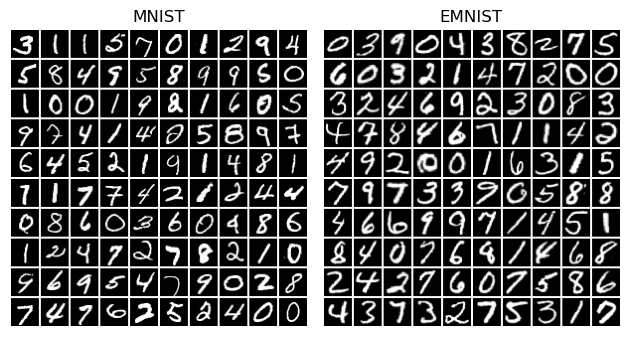

In [19]:
# EMNIST is transposed by default, need to undo to match MNIST
emnist_datamodule.transform.transforms.append(lambda img: img.transpose(-1, -2))

# Combine some images to show
rows = 10
cols = 10

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

idx = np.random.choice(55000, rows * cols)
imgs = mnist_datamodule.mnist_train.dataset.data[idx].reshape(rows, cols, 28, 28)
show_imgs(imgs, ax=ax[0])
ax[0].set_title('MNIST')

idx = np.random.choice(55000, rows * cols)
imgs = emnist_datamodule.mnist_train.dataset.data[idx].reshape(rows, cols, 28, 28).transpose(-1, -2)
show_imgs(imgs, ax=ax[1])
ax[1].set_title('EMNIST')

plt.tight_layout()

In [20]:
model.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
trainer.fit(model=model, datamodule=mnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 30.8 K
-----------------------------------
30.8 K    Trainable params
0         Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=30` reached.


2 1 [[['train_loss', 'val_loss']], [['train_acc', 'val_acc']]]


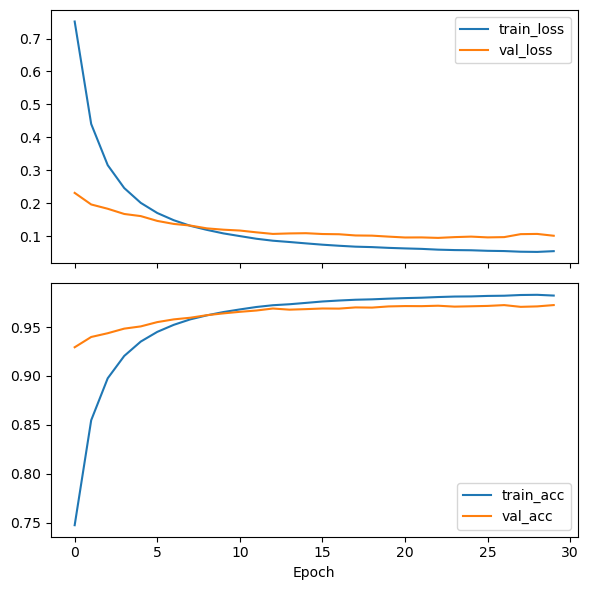

In [21]:
csv_path = os.path.join(trainer.loggers[0].log_dir, 'metrics.csv')
show_history_csv(
    csv_path,
    metrics=[
        [['train_loss', 'val_loss']],
        [['train_acc', 'val_acc']]
    ],
    smoothing=0.75,
)


plt.tight_layout()

In [22]:
# Get more accurate metrics
print(f'===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===')
print(f'--- Accuracy / Loss for MNIST dataset:')
trainer.validate(
    model=model,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'--- Accuracy / Loss for EMNIST dataset:')
trainer.validate(
    model=model,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(model.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===
--- Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9882181882858276       0.9765999913215637
        val_loss           0.036220673471689224      0.08473416417837143
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Accuracy / Loss for EMNIST dataset:


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8576908707618713       0.8569999933242798
        val_loss            0.5504840612411499       0.5598312616348267
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 60.21%


# 1. Adapt the model to the new dataset w/o freezing

In [52]:
config_ft = {
    'freeze': [
        'embedding',
    ],
    'train': {
        'learning_rate': 1e-3,
        'weight_decay': 1e-2,
        'num_epochs': 5,
    },
}

model_ft = copy.deepcopy(model)
freeze_layers(model_ft.model, config_ft['freeze'])
print(num_parameters(model_ft.model, as_table=True))

     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |         0 |         0.00%
encoder.blocks.0 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.1 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.2 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.3 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
classifier       |    250 |       250 |       100.00%
---------------- | ------ | --------- | -------------
           Total | 30,394 |    28,762 |        94.63%


In [53]:
%%time

model_ft.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config_ft['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
trainer.fit(model=model_ft, datamodule=emnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 30.8 K
-----------------------------------
29.1 K    Trainable params
1.6 K     Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 39.2 s, sys: 4.28 s, total: 43.5 s
Wall time: 13.3 s


In [54]:
# Get more accurate metrics
print(f'===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===')
print(f'--- Accuracy / Loss for MNIST dataset:')
trainer.validate(
    model=model_ft,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'--- Accuracy / Loss for EMNIST dataset:')
trainer.validate(
    model=model_ft,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(model_ft.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===
--- Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9220181703567505       0.9192000031471252
        val_loss            0.2415303736925125       0.2625061571598053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Accuracy / Loss for EMNIST dataset:


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.987781822681427       0.9807999730110168
        val_loss            0.03865835815668106      0.06853421777486801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 57.74%


# 2. Adapt the model to the new dataset w/ shallow freezing

In [55]:
config_ft_freeze1 = {
    'freeze': [
        'embedding',
        'encoder.blocks.0',
        'encoder.blocks.1',
    ],
    'train': {
        'learning_rate': 1e-3,
        'weight_decay': 1e-2,
        'num_epochs': 5,
    },
}

model_ft_freeze1 = copy.deepcopy(model)
freeze_layers(model_ft_freeze1.model, config_ft_freeze1['freeze'])
print(num_parameters(model_ft_freeze1.model, as_table=True))

     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |         0 |         0.00%
encoder.blocks.0 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
encoder.blocks.1 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
encoder.blocks.2 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
encoder.blocks.3 |        |           |              
| attention      |  2,400 |     2,400 |       100.00%
| mlp            |  4,728 |     4,728 |       100.00%
classifier       |    250 |       250 |       100.00%
---------------- | ------ | --------- | -------------
           Total | 30,394 |    14,506 |        47.73%


In [56]:
%%time

model_ft_freeze1.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config_ft_freeze1['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
trainer.fit(model=model_ft_freeze1, datamodule=emnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 30.8 K
-----------------------------------
14.7 K    Trainable params
16.1 K    Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 35.5 s, sys: 4.35 s, total: 39.9 s
Wall time: 9.89 s


In [57]:
# Get more accurate metrics
print(f'===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===')
print(f'--- Accuracy / Loss for MNIST dataset:')
trainer.validate(
    model=model_ft_freeze1,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'--- Accuracy / Loss for EMNIST dataset:')
trainer.validate(
    model=model_ft_freeze1,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(model_ft_freeze1.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===
--- Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9489636421203613       0.9441999793052673
        val_loss            0.16623860597610474      0.19870543479919434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Accuracy / Loss for EMNIST dataset:


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9874727129936218       0.9797999858856201
        val_loss            0.03989087790250778      0.0728893131017685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 54.56%


# 3. Adapt the model to the new dataset w/ deep freezing

In [58]:
config_ft_freeze2 = {
    'freeze': [
        'embedding',
        'encoder.blocks.0',
        'encoder.blocks.1',
        'encoder.blocks.2',
        'encoder.blocks.3',
    ],
    'train': {
        'learning_rate': 1e-3,
        'weight_decay': 1e-2,
        'num_epochs': 5,
    },
}

model_ft_freeze2 = copy.deepcopy(model)
freeze_layers(model_ft_freeze2.model, config_ft_freeze2['freeze'])
print(num_parameters(model_ft_freeze2.model, as_table=True))

     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |         0 |         0.00%
encoder.blocks.0 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
encoder.blocks.1 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
encoder.blocks.2 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
encoder.blocks.3 |        |           |              
| attention      |  2,400 |         0 |         0.00%
| mlp            |  4,728 |         0 |         0.00%
classifier       |    250 |       250 |       100.00%
---------------- | ------ | --------- | -------------
           Total | 30,394 |       250 |         0.82%


In [59]:
%%time

model_ft_freeze2.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config_ft_freeze2['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
trainer.fit(model=model_ft_freeze2, datamodule=emnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 30.8 K
-----------------------------------
250       Trainable params
30.5 K    Non-trainable params
30.8 K    Total params
0.123     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 32.3 s, sys: 4.28 s, total: 36.6 s
Wall time: 6.75 s


In [60]:
# Get more accurate metrics
print(f'===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===')
print(f'--- Accuracy / Loss for MNIST dataset:')
trainer.validate(
    model=model_ft_freeze2,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'--- Accuracy / Loss for EMNIST dataset:')
trainer.validate(
    model=model_ft_freeze2,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(model_ft_freeze2.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===
--- Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.921854555606842       0.9067999720573425
        val_loss            0.2225029617547989       0.28115618228912354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Accuracy / Loss for EMNIST dataset:


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.955581784248352       0.9517999887466431
        val_loss            0.14157383143901825      0.15423257648944855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 51.70%


# 4. Adapt the model with LoRA

In [103]:
from utils.peft import register_lora_hook_all_linear

config_lora = {
    'freeze': [
        'embedding',
        'encoder',
        'classifier',
    ],
    'unless': [
        'residual_a',
        'residual_b',
    ],
    'train': {
        'learning_rate': 1e-3,
        'weight_decay': 1e-2,
        'num_epochs': 5,
    },
}

model_lora = copy.deepcopy(model)
register_lora_hook_all_linear(model_lora, rank=2)

freeze_layers(model_lora.model, config_lora['freeze'], config_lora['unless'])
print(num_parameters(model_lora.model, as_table=True))

     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |         0 |         0.00%
encoder.blocks.0 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.1 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.2 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.3 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
classifier       |    318 |        68 |        21.38%
---------------- | ------ | --------- | -------------
           Total | 35,646 |     5,252 |        14.73%


In [86]:
%%time

model_lora.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config_lora['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
trainer.fit(model=model_lora, datamodule=emnist_datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 36.0 K
-----------------------------------
5.3 K     Trainable params
30.8 K    Non-trainable params
36.0 K    Total params
0.144     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 42.8 s, sys: 4.6 s, total: 47.4 s
Wall time: 17.4 s


In [87]:
# Get more accurate metrics
print(f'===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===')
print(f'--- Accuracy / Loss for MNIST dataset:')
trainer.validate(
    model=model_lora,
    dataloaders=[mnist_datamodule.train_dataloader(),
                 mnist_datamodule.val_dataloader()])
print(f'--- Accuracy / Loss for EMNIST dataset:')
trainer.validate(
    model=model_lora,
    dataloaders=[emnist_datamodule.train_dataloader(),
                 emnist_datamodule.val_dataloader()])

mia_scores = simple_mia(model_lora.model,
                        mnist_datamodule.train_dataloader(),
                        emnist_datamodule.train_dataloader(),
                        nn.CrossEntropyLoss(reduction='none'),
                        n_splits=10,
                        max_samples_per_subset=100_000)
print(f'--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: {mia_scores.mean():.2%}')

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


===> NOTE: "DataLoader 0" and "DataLoader 1" are the training and validation sets <===
--- Accuracy / Loss for MNIST dataset:


/home/takeshi/micromamba/envs/ai/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |                                                                                                 …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9592000246047974        0.951200008392334
        val_loss            0.12860873341560364      0.1649862676858902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Accuracy / Loss for EMNIST dataset:


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9888363480567932       0.9793999791145325
        val_loss           0.036618925631046295      0.06930036842823029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- MIA score for MNIST(member) vs. EMNIST(non-member) dataset: 54.31%


# Differential Privacy with Opacus

We will create custom configuration and optimizers to enable the training

In [111]:
from opacus import PrivacyEngine
from opacus.data_loader import DPDataLoader
from opacus.lightning import DPLightningDataModule

In [140]:
config = {
    'dp': {
        'delta': 1e-5,
        'noise_multiplier': 1.0,
        'max_grad_norm': 1.0,
        'sample_rate': 0.001,
    },
    'model': {
        'patch_size': 4,
        'hidden_size': 24,
        'num_hidden_layers': 4,
        'num_attention_heads': 4,
        'intermediate_size': 4 * 24,
        'hidden_dropout': 0.0,
        'attention_probs_dropout': 0.0,
        'position_method': 'random',
        'image_size': 28,
        'num_classes': 10,
        'num_channels': 1,
        'qkv_bias': True,
    },
    'train': {
        'learning_rate': 1e-3,
        'weight_decay': 1e-2,
        'num_epochs': 30,
    },
    'data': {
        'batch_size': 256,
    }
}

class DPViTLightning(ViTLightning):
    def __init__(self, config, train_accuracy=False):
        super().__init__(config, train_accuracy=train_accuracy)
        self.privacy_engine = None  # PrivacyEngine()

    # def configure_optimizers(self):
    #     optimizer = super().configure_optimizers()
        
    #     print(dir(self.trainer))
    #     train_dataloader = self.trainer._data_connector._train_dataloader_source.dataloader()

        

    #     if hasattr(self, 'dp'):
    #         self.dp['model'].remove_hooks()
        
    #     dp_model, optimizer, dataloader = self.privacy_engine.make_private(
    #         module=self,
    #         optimizer=optimizer,
    #         data_loader=train_dataloader,
    #         noise_multiplier=self.config['dp']['noise_multiplier'],
    #         max_grad_norm=self.config['dp']['max_grad_norm'],
    #         poisson_sampling=isinstance(train_dataloader, DPDataLoader)
    #     )
    #     self.dp = {'model': dp_model}
    #     return optimizer

    def on_train_start(self):
        self.privacy_engine = PrivacyEngine(
            self,
            sample_rate = self.config['dp']['sample_rate'],
            noise_multiplier=self.config['dp']['noise_multiplier'],
            max_grad_norm = self.config['dp']['max_grad_norm'],
        )

    def on_train_epoch_end(self):
        epsilon = self.privacy_engine.get_epsilon(self.config['dp']['delta'])
        self.log('epsilon', epsilon, on_epoch=True, prog_bar=True)

In [141]:
dp_emnist_datamodule = DPLightningDataModule(emnist_datamodule)

# Create LoRA model
dp_model = DPViTLightning(config, train_accuracy=True)
dp_model.model = copy.deepcopy(model.model)
register_lora_hook_all_linear(dp_model.model, rank=2)

freeze_layers(dp_model.model, config_lora['freeze'], config_lora['unless'])
print(num_parameters(dp_model.model, as_table=True))


dp_model.train_accuracy=True
trainer = pl.Trainer(
    max_epochs=config['train']['num_epochs'],
    logger=pl.loggers.CSVLogger('.'),
)
# trainer.fit(model=dp_model, datamodule=dp_emnist_datamodule)
trainer.fit(
    model=dp_model,
    train_dataloaders=DPDataLoader.from_data_loader(
        dp_emnist_datamodule.train_dataloader()
    )
)

01/31/2024 02:08:56:INFO:GPU available: True (cuda), used: True
01/31/2024 02:08:56:INFO:TPU available: False, using: 0 TPU cores
01/31/2024 02:08:56:INFO:IPU available: False, using: 0 IPUs
01/31/2024 02:08:56:INFO:HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | ViTModel | 36.0 K
-----------------------------------
5.3 K     Trainable params
30.8 K    Non-trainable params
36.0 K    Total params
0.144     Total estimated model params size (MB)


     Layer       | Total  | Trainable | Trainable (%)
---------------- | ------ | --------- | -------------
embedding        |  1,632 |         0 |         0.00%
encoder.blocks.0 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.1 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.2 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
encoder.blocks.3 |        |           |              
| attention      |  3,216 |       816 |        25.37%
| mlp            |  5,208 |       480 |         9.22%
classifier       |    318 |        68 |        21.38%
---------------- | ------ | --------- | -------------
           Total | 35,646 |     5,252 |        14.73%


Training: |                                                                                                   …

TypeError: PrivacyEngine.__init__() got an unexpected keyword argument 'sample_rate'

In [124]:
isinstance(dp_emnist_datamodule, nn.Module)

False